Dataset loaded: (3410, 1024) (3410,)
Example label: 0

PLA Results
Accuracy: 0.9765395894428153 Precision: 0.0 Recall: 0.0 F1: 0.0


c:\Users\Darsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


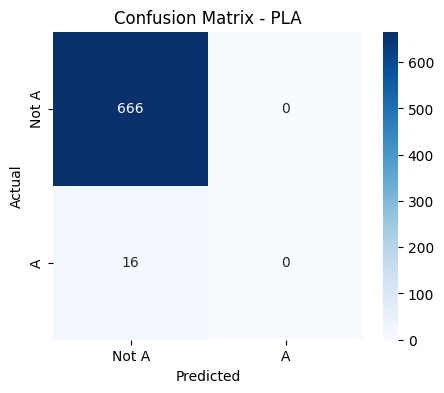

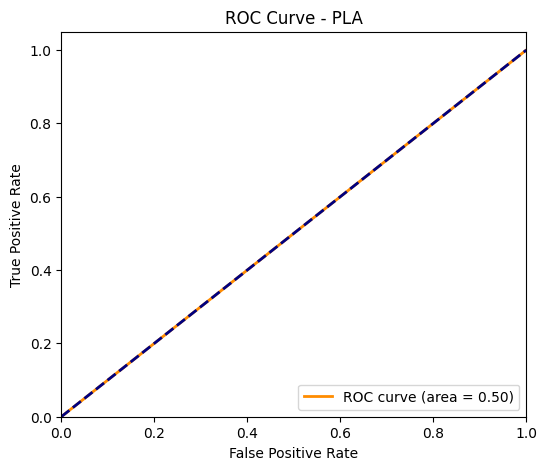

In [7]:
# ================================
# Experiment 5: PLA vs MLP (PyTorch)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# ================================
# 1. Preprocess Dataset (CSV + flat folder)
# ================================
IMG_SIZE = 32

import pandas as pd
from PIL import Image

import numpy as np
import os

IMG_SIZE = 32



def load_dataset(csv_path="english.csv", img_dir="Img"):
    data = pd.read_csv(csv_path)
    X, y = [], []

    for _, row in data.iterrows():
        # Clean up filename (remove any "Img/" prefix in CSV)
        filename = os.path.basename(row['image'])   # keeps only "img001-001.png"
        img_path = os.path.join(img_dir, filename)
        label = row['label']

        # Load & preprocess
        img = Image.open(img_path).convert("L")
        img = img.resize((IMG_SIZE, IMG_SIZE))
        X.append(np.array(img).flatten() / 255.0)
        y.append(label)

    return np.array(X, dtype=np.float32), np.array(y)

# Example usage
X, y = load_dataset("english.csv", "Img")

print("Dataset loaded:", X.shape, y.shape)
print("Example label:", y[0])



# ================================
# Train-Test Split + Encoding
# ================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)
y_test_bin = lb.transform(y_test)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(np.argmax(y_train_bin, axis=1), dtype=torch.long)
y_test_t = torch.tensor(np.argmax(y_test_bin, axis=1), dtype=torch.long)
# ================================
# 2. PLA (Perceptron from scratch)
# ================================
class PLA:
    def __init__(self, input_dim, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.weights = np.zeros(input_dim)
        self.bias = 0

    def activation(self, x):
        return np.where(x >= 0, 1, 0)

    def fit(self, X, y):
        for _ in range(self.epochs):
            for xi, target in zip(X, y):
                linear_output = np.dot(xi, self.weights) + self.bias
                y_pred = self.activation(linear_output)
                update = self.lr * (target - y_pred)
                self.weights += update * xi
                self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.activation(linear_output)

# Convert to binary problem for PLA (class 'A' vs rest)
y_binary = (y_train == 'A').astype(int)
y_binary_test = (y_test == 'A').astype(int)

pla = PLA(input_dim=X_train.shape[1], lr=0.01, epochs=10)
pla.fit(X_train, y_binary)
y_pred_pla = pla.predict(X_test)

pla_acc = accuracy_score(y_binary_test, y_pred_pla)
pla_prec = precision_score(y_binary_test, y_pred_pla)
pla_rec = recall_score(y_binary_test, y_pred_pla)
pla_f1 = f1_score(y_binary_test, y_pred_pla)

print("\nPLA Results")
print("Accuracy:", pla_acc, "Precision:", pla_prec, "Recall:", pla_rec, "F1:", pla_f1)

# ================================
# Confusion Matrix
# ================================
cm = confusion_matrix(y_binary_test, y_pred_pla)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not A", "A"], yticklabels=["Not A", "A"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - PLA")
plt.show()

# ================================
# ROC Curve
# ================================
fpr, tpr, thresholds = roc_curve(y_binary_test, y_pred_pla)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - PLA")
plt.legend(loc="lower right")
plt.show()



MLP Results
Accuracy: 0.06744868035190615 Precision: 0.038602502034618374 Recall: 0.08266845162006452 F1: 0.03661354210864415


c:\Users\Darsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


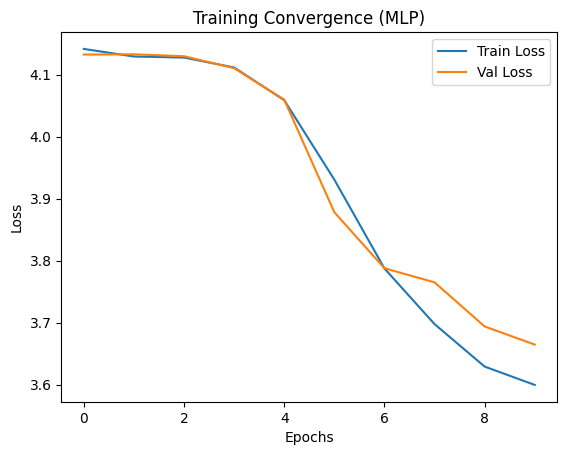

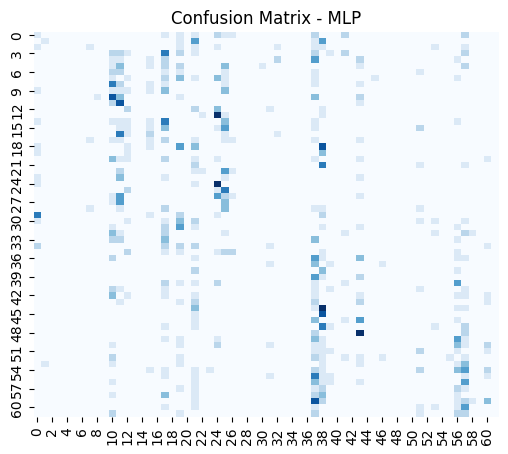

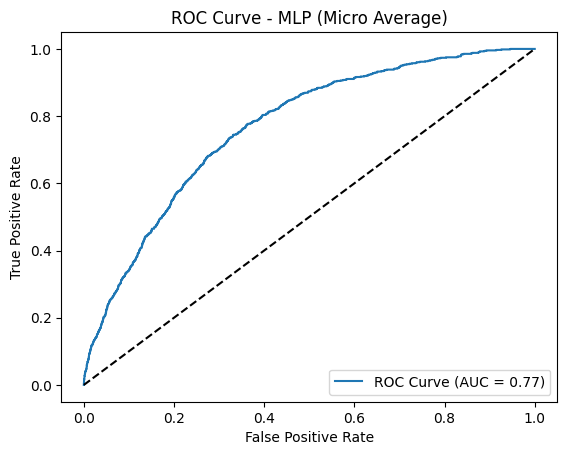

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode string labels (A, B, C, ..., 0,1,2...)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train_enc, dtype=torch.long)
y_test_t = torch.tensor(y_test_enc, dtype=torch.long)

# ================================
# 3. MLP (PyTorch)
# ================================
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim, activation="relu"):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_dim
        act_fn = nn.ReLU() if activation == "relu" else nn.Sigmoid()
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(act_fn)
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# ================================
# 4. Train Function (Hyperparameter Tuning)
# ================================
def train_mlp(hidden_layers=[128,64], activation="relu", optimizer_name="adam", lr=0.001, batch_size=32, epochs=10):
    model = MLP(input_dim=X_train.shape[1], hidden_layers=hidden_layers,
                output_dim=len(lb.classes_), activation=activation)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_name=="adam" else optim.SGD(model.parameters(), lr=lr)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size)

    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss/len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for xb, yb in test_loader:
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
            val_losses.append(val_loss/len(test_loader))

    return model, train_losses, val_losses

# Train MLP with chosen params
mlp_model, train_losses, val_losses = train_mlp(hidden_layers=[128,64], activation="relu",
                                               optimizer_name="adam", lr=0.001, batch_size=32, epochs=10)

# ================================
# 5. Evaluate MLP
# ================================
mlp_model.eval()
with torch.no_grad():
    y_pred_logits = mlp_model(X_test_t)
    y_pred_classes = torch.argmax(y_pred_logits, dim=1).numpy()

mlp_acc = accuracy_score(y_test_t, y_pred_classes)
mlp_prec = precision_score(y_test_t, y_pred_classes, average="macro")
mlp_rec = recall_score(y_test_t, y_pred_classes, average="macro")
mlp_f1 = f1_score(y_test_t, y_pred_classes, average="macro")

print("\nMLP Results")
print("Accuracy:", mlp_acc, "Precision:", mlp_prec, "Recall:", mlp_rec, "F1:", mlp_f1)

# ================================
# 6. Convergence Curves
# ================================
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Convergence (MLP)")
plt.legend()
plt.show()

# ================================
# 7. Confusion Matrix
# ================================
cm = confusion_matrix(y_test_t, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - MLP")
plt.show()

# ================================
# 8. ROC Curve (Micro-average)
# ================================
y_test_bin_t = torch.tensor(y_test_bin, dtype=torch.float32)
fpr, tpr, _ = roc_curve(y_test_bin_t.numpy().ravel(), torch.softmax(y_pred_logits, dim=1).numpy().ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP (Micro Average)")
plt.legend(loc="lower right")
plt.show()


Epoch 1/50 | Train Loss: 3.9575 | Val Loss: 3.7907 | Val Acc: 0.0968
Epoch 2/50 | Train Loss: 3.3755 | Val Loss: 3.3704 | Val Acc: 0.1935
Epoch 3/50 | Train Loss: 2.9419 | Val Loss: 3.0767 | Val Acc: 0.2507
Epoch 4/50 | Train Loss: 2.5906 | Val Loss: 2.9299 | Val Acc: 0.2962
Epoch 5/50 | Train Loss: 2.2972 | Val Loss: 2.8213 | Val Acc: 0.2962
Epoch 6/50 | Train Loss: 2.0502 | Val Loss: 2.7236 | Val Acc: 0.3270
Epoch 7/50 | Train Loss: 1.8476 | Val Loss: 2.9778 | Val Acc: 0.2434
Epoch 8/50 | Train Loss: 1.7132 | Val Loss: 2.4063 | Val Acc: 0.3974
Epoch 9/50 | Train Loss: 1.5579 | Val Loss: 2.3219 | Val Acc: 0.3842
Epoch 10/50 | Train Loss: 1.4463 | Val Loss: 2.6301 | Val Acc: 0.3006
Epoch 11/50 | Train Loss: 1.3153 | Val Loss: 2.4396 | Val Acc: 0.3592
Epoch 12/50 | Train Loss: 1.2313 | Val Loss: 2.2939 | Val Acc: 0.3695
Epoch 13/50 | Train Loss: 1.0922 | Val Loss: 1.8560 | Val Acc: 0.4941
Epoch 14/50 | Train Loss: 1.0067 | Val Loss: 2.0175 | Val Acc: 0.4604
Epoch 15/50 | Train Loss: 0.9

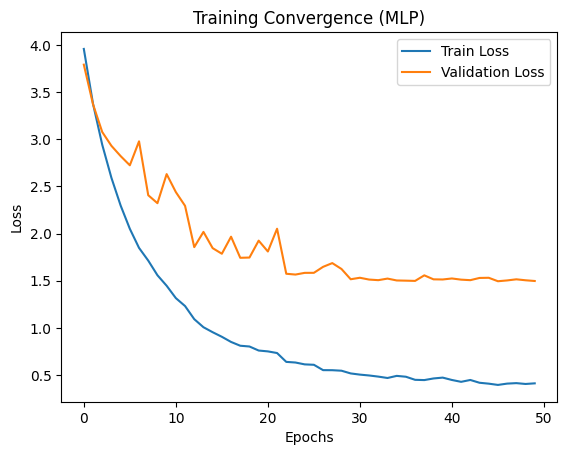

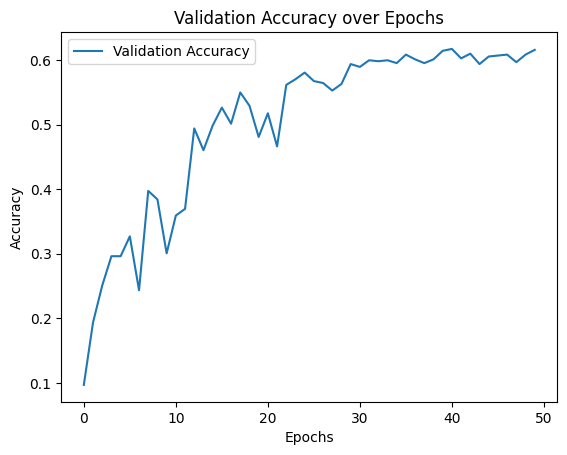

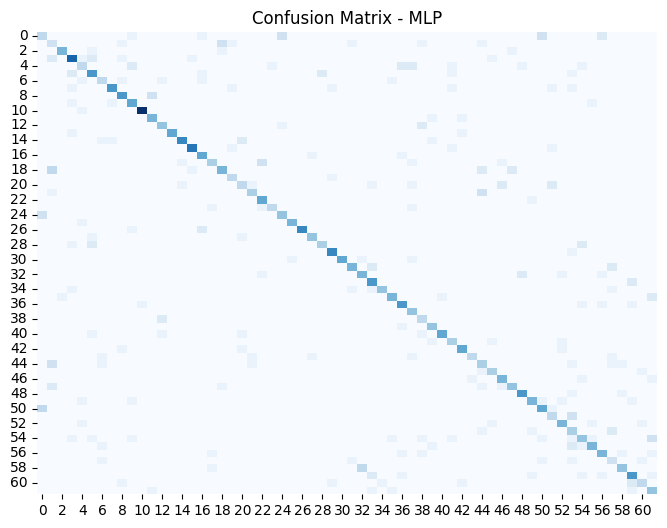

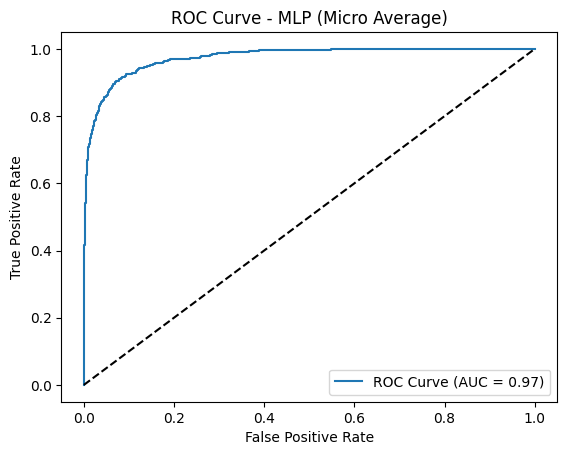

In [3]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_train_t = torch.tensor(y_train_enc, dtype=torch.long)
y_test_t = torch.tensor(y_test_enc, dtype=torch.long)

# ================================
# 2. Define MLP Model
# ================================
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim):
        super(MLP, self).__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.BatchNorm1d(h))   # normalize
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))     # regularize
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# ================================
# 3. Training Function
# ================================
def train_mlp(hidden_layers=[512,256,128], lr=0.001, batch_size=64, epochs=30):
    model = MLP(input_dim=X_train.shape[1],
                hidden_layers=hidden_layers,
                output_dim=len(le.classes_))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size)

    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

        # Validation
        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        val_losses.append(val_loss / len(test_loader))
        val_acc = correct / total
        val_accs.append(val_acc)

        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    return model, train_losses, val_losses, val_accs

# ================================
# 4. Train Model
# ================================
mlp_model, train_losses, val_losses, val_accs = train_mlp(epochs=50)

# ================================
# 5. Evaluate Model
# ================================
mlp_model.eval()
with torch.no_grad():
    y_pred_logits = mlp_model(X_test_t)
    y_pred_classes = torch.argmax(y_pred_logits, dim=1).numpy()

mlp_acc = accuracy_score(y_test_enc, y_pred_classes)
mlp_prec = precision_score(y_test_enc, y_pred_classes, average="macro")
mlp_rec = recall_score(y_test_enc, y_pred_classes, average="macro")
mlp_f1 = f1_score(y_test_enc, y_pred_classes, average="macro")

print("\nFinal MLP Results")
print("Accuracy:", mlp_acc, "Precision:", mlp_prec, "Recall:", mlp_rec, "F1:", mlp_f1)

# ================================
# 6. Plots
# ================================
# Loss curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Convergence (MLP)")
plt.legend()
plt.show()

# Accuracy curve
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - MLP")
plt.show()

# ROC Curve (micro-average)
y_test_bin = np.eye(len(le.classes_))[y_test_enc]
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), torch.softmax(y_pred_logits, dim=1).numpy().ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP (Micro Average)")
plt.legend(loc="lower right")
plt.show()